In [1]:
import pandas as pd
from urllib.request import urlretrieve
import os

In [2]:
urls = ['https://www.abs.gov.au/statistics/people/population/regional-population-age-and-sex/2021/32350DS0001_2021.xlsx', \
       'https://www.abs.gov.au/statistics/people/population/deaths-australia/2020/33020DO005_2020.xlsx', \
       'https://www.abs.gov.au/statistics/people/education/schools/2021/Table%2035b%20Counts%20of%20all%20Schools%2C%202010-2021.xlsx']

names = ['age_sex', 'pop_deaths', 'education']

In [3]:
# Setting PATH for downloads

output_relative_dir = '../data/raw/'
if not os.path.exists(output_relative_dir):
    os.makedirs(output_relative_dir)
    
# Creates abs_data folder within raw_data
if not os.path.exists(output_relative_dir + 'abs_data'):
    os.makedirs(output_relative_dir + 'abs_data')
    
abs_output_dir = output_relative_dir + 'abs_data'

In [4]:
# Downloading the .xlsx files

i = 0
for url in urls:
    output_dir = f"{abs_output_dir}/{names[i]}.xlsx"
    print(f'File {i+1} started.')
    urlretrieve(url, output_dir)
    print(f'File {i+1} finished.')
    i += 1

File 1 started.
File 1 finished.
File 2 started.
File 2 finished.
File 3 started.
File 3 finished.


## Reading in pop_deaths -

- `pop_deaths` contains information about the estimated resident population, recorded deaths and standardised death rate across each LGA
- Sheet 2 contains VIC info

In [5]:
df = pd.read_excel('../data/raw/abs_data/pop_deaths.xlsx', sheet_name = 2, skiprows = 4, header = [0,1], nrows = 129)[1:]
df = df.drop([(y, 'Standardised death rate.1') for y in range(2012, 2020)], axis=1)
df = df.drop([(y, 'Standardised death rate') for y in range(2012, 2021)], axis=1)
df.columns = [('LGA Code'), ('LGA Name')] + [','.join([str(c) for c in x]) for x in df.columns[2:]]
df2 = df.melt(id_vars=["LGA Code", "LGA Name"])
df2 = df2.dropna()
df2['value'] = df2.value.astype('int')
df2[['year','var']] = df2['variable'].str.split(',').tolist()
df2 = df2.sort_values('year')

# How to make graph less noisy?

- Could sample 30-50 rows, show 3 visualisations + map 
- Could only select areas (suburbs) of interest
- Could show upper, middle and lower areas + map

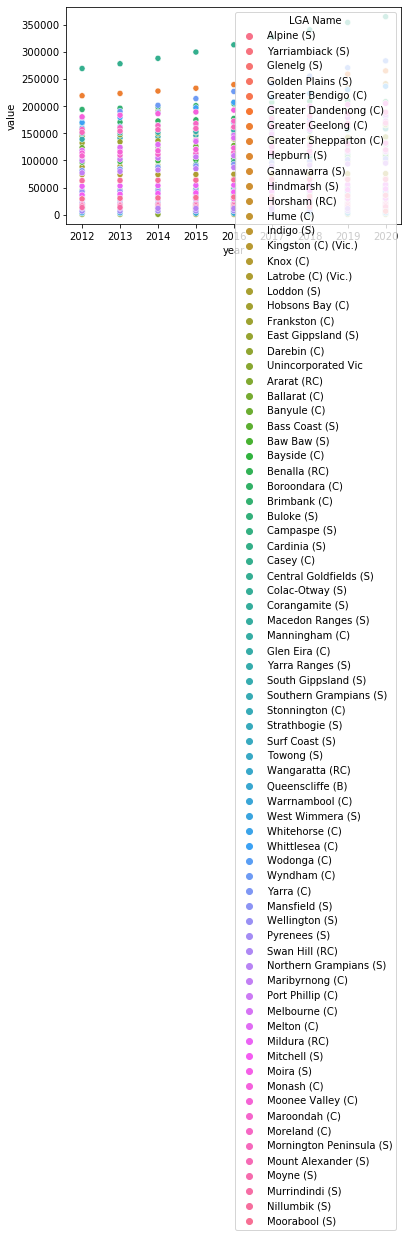

In [6]:
import seaborn as sns

df3 = df2.loc[df2['var'] == 'Estimated resident population']

sns.scatterplot(data = df3, x='year', y='value', hue='LGA Name')

In [7]:
# Forecasting population

df3.groupby(['LGA Code', 'LGA Name'])['value'].apply(pd.Series.pct_change)

0            NaN
78           NaN
22           NaN
23           NaN
24           NaN
          ...   
1445    0.012658
1446    0.004424
1447    0.006384
1448    0.001843
1470   -0.007383
Name: value, Length: 720, dtype: float64

# DF2 -

### Contains:
- Seperated by LGA
- Data over 9 years [2012 - 2020] for estimated resident population and death count

In [8]:
df2['variable'].unique()

array(['2012,Estimated resident population', '2012,Deaths', '2013,Deaths',
       '2013,Estimated resident population', '2014,Deaths',
       '2014,Estimated resident population', '2015,Deaths',
       '2015,Estimated resident population', '2016,Deaths',
       '2016,Estimated resident population', '2017,Deaths',
       '2017,Estimated resident population', '2018,Deaths',
       '2018,Estimated resident population', '2019,Deaths',
       '2019,Estimated resident population', '2020,Deaths',
       '2020,Estimated resident population'], dtype=object)

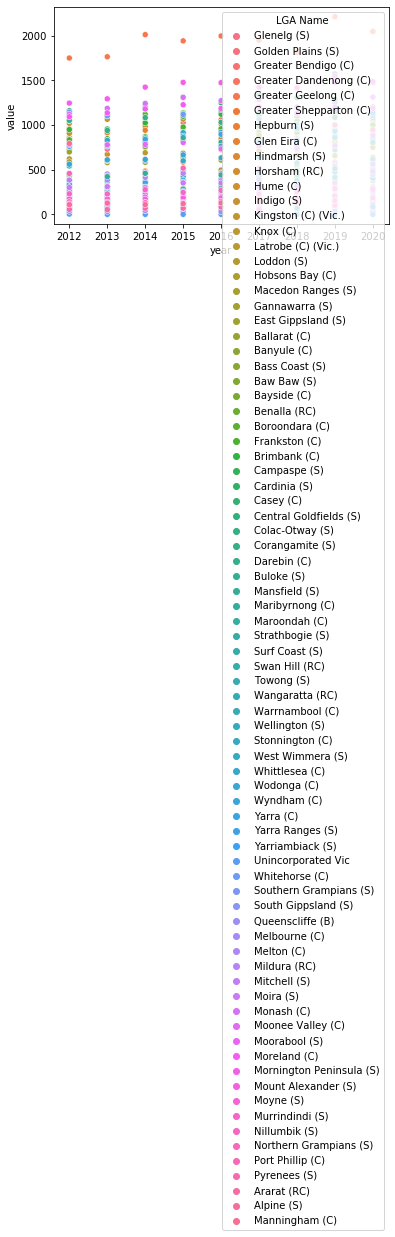

In [9]:
df3 = df2.loc[df2['var'] == 'Deaths']

sns.scatterplot(data = df3, x='year', y='value', hue='LGA Name')

# age_sex (2021) -

- Contains information about the estimated resident population, binned by ages
- 1st sheet males
- 2nd sheet females
- 3rd sheet combined
- Seperated by SA2, not LGA
- Sheets are not seperated by state, so will need to read all of them in and retain only VIC

In [10]:
df = pd.read_excel('../data/raw/abs_data/pop_deaths.xlsx', sheet_name = 2, skiprows = 4, header = [0,1], nrows = 129)[1:]

In [11]:
male_age = pd.read_excel('../data/raw/abs_data/age_sex.xlsx', sheet_name = 1, skiprows = 4, header = [0,1], nrows = 18692)[1:]
female_age = pd.read_excel('../data/raw/abs_data/age_sex.xlsx', sheet_name = 2, skiprows = 4, header = [0,1], nrows = 18692)[1:]
total_age = pd.read_excel('../data/raw/abs_data/age_sex.xlsx', sheet_name = 3, skiprows = 4, header = [0,1], nrows = 18692)[1:]

In [12]:
male_columns = ['S/T code', 'S/T name', 'GCCSA code', 'GCCSA name', 'SA4 code', 'SA4 name', 'SA3 code', 'SA3 name', 'SA2 code', 'SA2 name', \
          '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', \
          '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 and over', 'Total males']

female_columns = ['S/T code', 'S/T name', 'GCCSA code', 'GCCSA name', 'SA4 code', 'SA4 name', 'SA3 code', 'SA3 name', 'SA2 code', 'SA2 name', \
          '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', \
          '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 and over', 'Total females']

total_columns = ['S/T code', 'S/T name', 'GCCSA code', 'GCCSA name', 'SA4 code', 'SA4 name', 'SA3 code', 'SA3 name', 'SA2 code', 'SA2 name', \
          '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', \
          '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 and over', 'Total persons']

In [13]:
male_age.columns = male_columns
male_age.drop(male_age.index[[0,1]], inplace = True)
#male_age.dropna(inplace = True)

female_age.columns = female_columns
female_age.drop(female_age.index[[0,1]], inplace = True)
#female_age.dropna(inplace = True)

total_age.columns = total_columns
total_age.drop(total_age.index[[0,1]], inplace = True)
#total_age.dropna(inplace = True)

In [14]:
male_vic = male_age.loc[male_age['S/T name'] == 'Victoria']
female_vic = female_age.loc[female_age['S/T name'] == 'Victoria']
total_vic = total_age.loc[total_age['S/T name'] == 'Victoria']

In [15]:
total_vic.columns

Index(['S/T code', 'S/T name', 'GCCSA code', 'GCCSA name', 'SA4 code',
       'SA4 name', 'SA3 code', 'SA3 name', 'SA2 code', 'SA2 name', '0-4',
       '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44',
       '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84',
       '85 and over', 'Total persons'],
      dtype='object')

In [16]:
total_vic.head()

,S/T code,S/T name,GCCSA code,GCCSA name,SA4 code,SA4 name,SA3 code,SA3 name,SA2 code,SA2 name,...,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85 and over,Total persons
648,2,Victoria,2RVIC,Rest of Vic.,201,Ballarat,20101,Ballarat,201011001,Alfredton,...,1142,974,848,709,666,596,419,253,164,16823
649,2,Victoria,2RVIC,Rest of Vic.,201,Ballarat,20101,Ballarat,201011002,Ballarat,...,818,833,812,822,721,736,526,387,380,12076
650,2,Victoria,2RVIC,Rest of Vic.,201,Ballarat,20101,Ballarat,201011005,Buninyong,...,532,495,452,526,474,398,204,134,85,7232
651,2,Victoria,2RVIC,Rest of Vic.,201,Ballarat,20101,Ballarat,201011006,Delacombe,...,565,530,538,479,428,432,280,175,228,10640
652,2,Victoria,2RVIC,Rest of Vic.,201,Ballarat,20101,Ballarat,201011007,Smythes Creek,...,326,344,312,311,242,186,95,40,31,4213


# education

In [17]:
df = pd.read_excel('../data/raw/abs_data/education.xlsx', sheet_name = 3, skiprows = 4)

In [18]:
vic_education = df.loc[df['State/Territory'] == 'b Vic.']

In [19]:
vic_education.head(10)

,Year,State/Territory,Affiliation (Gov/Non-gov),Affiliation (Gov/Cath/Ind),School Type,School Count
12,2021,b Vic.,a Government,a Government,a Primary school,1137.0
13,2021,b Vic.,a Government,a Government,b Secondary school,247.0
14,2021,b Vic.,a Government,a Government,c Combined school,82.0
15,2021,b Vic.,a Government,a Government,d Special school,81.0
16,2021,b Vic.,b Non-Government,b Catholic,a Primary school,394.0
17,2021,b Vic.,b Non-Government,b Catholic,b Secondary school,84.0
18,2021,b Vic.,b Non-Government,b Catholic,c Combined school,14.0
19,2021,b Vic.,b Non-Government,b Catholic,d Special school,7.0
20,2021,b Vic.,b Non-Government,c Independent,a Primary school,40.0
21,2021,b Vic.,b Non-Government,c Independent,b Secondary school,9.0


In [20]:
vic_education

,Year,State/Territory,Affiliation (Gov/Non-gov),Affiliation (Gov/Cath/Ind),School Type,School Count
12,2021,b Vic.,a Government,a Government,a Primary school,1137.0
13,2021,b Vic.,a Government,a Government,b Secondary school,247.0
14,2021,b Vic.,a Government,a Government,c Combined school,82.0
15,2021,b Vic.,a Government,a Government,d Special school,81.0
16,2021,b Vic.,b Non-Government,b Catholic,a Primary school,394.0
...,...,...,...,...,...,...
1045,2010,b Vic.,b Non-Government,b Catholic,d Special school,8.0
1046,2010,b Vic.,b Non-Government,c Independent,a Primary school,46.0
1047,2010,b Vic.,b Non-Government,c Independent,b Secondary school,15.0
1048,2010,b Vic.,b Non-Government,c Independent,c Combined school,140.0


## Have change in school (type) distribution over 11 years

- Compare to median house price over the 11 years
- Can establish trend for schooling demographic + forecasting future median house price (based on schools) for 3 years as required
- Could create regression model: y = median house price, X = [# of government, catholic, indept, etc schools]

# The number of schools in Victoria has remained fairly constant over the 11 years

- Explore why

In [21]:
vic_education.groupby(by = 'Year').mean()

,School Count
Year,
2010,187.583333
2011,186.166667
2012,186.083333
2013,184.916667
2014,184.750000
2015,185.250000
2016,185.416667
2017,186.083333
2018,186.500000


# Naive approach - 
## Most liveable suburb == most expensive 

In [22]:
properties = pd.read_csv('../data/curated/2022-09-18 12_34_18.198964.csv')

/tmp/ipykernel_278/348927084.py:1: DtypeWarning: Columns (5,6,7,10,11,16,18,22,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  properties = pd.read_csv('../data/curated/2022-09-18 12_34_18.198964.csv')


In [23]:
properties.columns

Index(['link', 'address', 'map_link', 'lat', 'lng', 'sold_price_',
       'sold_date_', 'land_size_', 'property_type', 'Bed rooms_',
       'last_sold_price_', 'last_sold_date_', 'agent', 'rent_price_',
       'rent_date_', 'Bath rooms_', 'Car spaces_', 'page', 'list_text_',
       'source', 'suburb', 'sold_price', 'sold_date', 'land_size',
       'building_size', 'bed', 'bath', 'car', 'rent_price', 'rent_date',
       'last_sold_price', 'last_sold_date', 'list', 'is_over', 'minlist',
       'maxlist'],
      dtype='object')

In [24]:
properties

,link,address,map_link,lat,lng,sold_price_,sold_date_,land_size_,property_type,Bed rooms_,...,bath,car,rent_price,rent_date,last_sold_price,last_sold_date,list,is_over,minlist,maxlist
0,http://house.speakingsame.com/p.php?q=Mentone&...,33 Mundy Street,http://house.speakingsame.com/map.php?addr=33+...,-37.984010,145.056010,"$2,069,999",Sep 2022,719 sqm,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,http://house.speakingsame.com/p.php?q=Mentone&...,2/21-23 Florence Street,http://house.speakingsame.com/map.php?addr=2%2...,-37.982060,145.061010,"$410,000",Sep 2022,56 sqm,Unit,1,...,NaN,NaN,NaN,NaN,410000.0,2022-09-01,NaN,NaN,NaN,NaN
2,http://house.speakingsame.com/p.php?q=Mentone&...,4 Rogers Street,http://house.speakingsame.com/map.php?addr=4+R...,-37.985233,145.068389,"$1,910,000",Sep 2022,853 sqm,House,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://house.speakingsame.com/p.php?q=Mentone&...,1/160 Warrigal Road,http://house.speakingsame.com/map.php?addr=1%2...,-37.978116,145.072367,"$740,000",Sep 2022,341 sqm,Townhouse,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,http://house.speakingsame.com/p.php?q=Mentone&...,1/10 Commercial Road,http://house.speakingsame.com/map.php?addr=1%2...,-37.985533,145.065867,"$595,000",Sep 2022,818 sqm,Apartment,3,...,1.0,1.0,435.0,2018-10-01,595000.0,2022-09-01,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80647,http://house.speakingsame.com/rp.php?q=St+Andr...,9 BASS MEADOWS BOULEVARD,http://house.speakingsame.com/map.php?addr=9+B...,-38.416080,144.830238,NaN,NaN,NaN,House,4,...,1.0,2.0,380.0,2011-05-01,NaN,NaN,NaN,NaN,NaN,NaN
80648,http://house.speakingsame.com/rp.php?q=St+Andr...,9 Bass Meadows,http://house.speakingsame.com/map.php?addr=9+B...,-38.416080,144.830238,NaN,NaN,NaN,House,4,...,1.0,2.0,380.0,2011-05-01,NaN,NaN,NaN,NaN,NaN,NaN
80649,http://house.speakingsame.com/rp.php?q=St+Andr...,39 Alex Drive,http://house.speakingsame.com/map.php?addr=39+...,-38.418264,144.838224,NaN,NaN,NaN,House,3,...,3.0,2.0,350.0,2009-07-01,NaN,NaN,NaN,NaN,NaN,NaN
80650,http://house.speakingsame.com/rp.php?q=St+Andr...,1 Hadrian Avenue,http://house.speakingsame.com/map.php?addr=1+H...,-38.418423,144.833288,NaN,NaN,NaN,House,3,...,1.0,1.0,245.0,2008-05-01,NaN,NaN,NaN,NaN,NaN,NaN


## Finding the most expensive suburbs -

In [25]:
df = properties[['sold_price', 'suburb']]
test = df.groupby('suburb').mean().sort_values(by = 'sold_price')
test

,sold_price
suburb,
Sawmill Settlement,2.113055e+05
Seaspray,2.246241e+05
Maindample,3.242517e+05
Falls Creek,4.165425e+05
Tremont,4.205000e+05
...,...
Brighton,2.619116e+06
Toorak,2.666568e+06
Canterbury,2.703319e+06


In [26]:
expensive_10 = test[:10].index

In [27]:
df2

,LGA Code,LGA Name,variable,value,year,var
0,20110,Alpine (S),"2012,Estimated resident population",12183,2012,Estimated resident population
109,22410,Glenelg (S),"2012,Deaths",194,2012,Deaths
110,22490,Golden Plains (S),"2012,Deaths",85,2012,Deaths
111,22620,Greater Bendigo (C),"2012,Deaths",861,2012,Deaths
112,22670,Greater Dandenong (C),"2012,Deaths",960,2012,Deaths
...,...,...,...,...,...,...
1446,25490,Moyne (S),"2020,Estimated resident population",17027,2020,Estimated resident population
1447,25620,Murrindindi (S),"2020,Estimated resident population",14661,2020,Estimated resident population
1448,25710,Nillumbik (S),"2020,Estimated resident population",65219,2020,Estimated resident population
1470,27630,Yarriambiack (S),"2020,Estimated resident population",6588,2020,Estimated resident population
